In [5]:
# imports
import pandas as pd
import sqlite3 as lite
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
# adjust matplotlib setting
plt.style.use('fivethirtyeight')
matplotlib.rcParams.update({'font.size': 18})

In [7]:
# get a list of tables in the database
con = lite.connect('database.sqlite')

with con:
    
    cur = con.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
    
    rows = cur.fetchall()
    
    tables = [row[0] for row in rows]
    
print(tables)

['Country', 'sqlite_sequence', 'League', 'Match', 'Player', 'Player_Stats', 'Team']


In [8]:
# read in data from player & player_stats
player_df = pd.read_sql_query("SELECT * FROM Player", con)
stats_df = pd.read_sql_query("SELECT * FROM Player_Stats", con)

In [9]:
# inspect dataframes
player_df.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [10]:
# inspect dataframes
stats_df.head()

,id,player_fifa_api_id,player_api_id,date_stat,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67,71,right,medium,medium,49,...,54,48,65,69,69,6,11,10,8,8
1,2,218353,505942,2015-11-19 00:00:00,67,71,right,medium,medium,49,...,54,48,65,69,69,6,11,10,8,8
2,3,218353,505942,2015-09-21 00:00:00,62,66,right,medium,medium,49,...,54,48,65,66,69,6,11,10,8,8
3,4,218353,505942,2015-03-20 00:00:00,61,65,right,medium,medium,48,...,53,47,62,63,66,5,10,9,7,7
4,5,218353,505942,2007-02-22 00:00:00,61,65,right,medium,medium,48,...,53,47,62,63,66,5,10,9,7,7


In [11]:
# merge player & stats dataframes together
df = pd.merge(player_df, stats_df, how='inner', on='player_api_id')

# update date columns datatypes
df['birthday'] = pd.to_datetime(df['birthday'])
df['date_stat'] = pd.to_datetime(df['date_stat'])

# add an age in years columns
age = df['date_stat'] - df['birthday']
df['age'] = [i.year - 1970 for i in pd.to_datetime(age)]

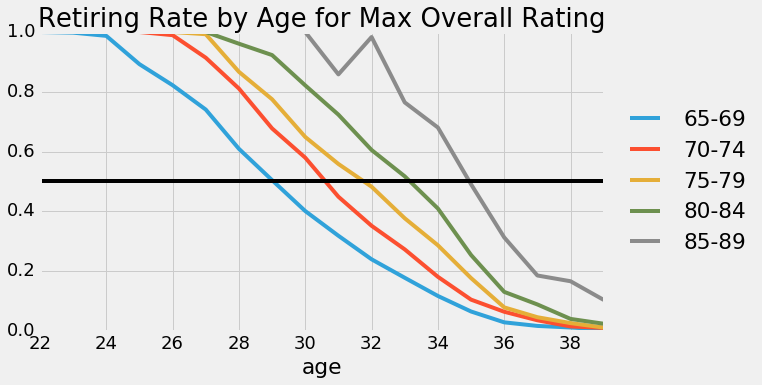

In [12]:
def retiredplot(ratinglist):
    '''Plots a line graph of retiring rate based on max overall rating'''
    
    for rating in ratinglist:    
        # groupby player_api_id and find the max rating; update column names
        max_rate_df = df.groupby('player_api_id')['overall_rating'].max().reset_index()
        max_rate_df.columns = ['player_api_id','max_rating']
        
        # merge max rating on main df; remove ages with little data
        retire_df = pd.merge(max_rate_df, df, how='left', on='player_api_id')
        retire_df = retire_df[(retire_df.age > 19) & (retire_df.age < 40)]
        
        # only include a 5 value range of max values
        rating_4 = rating + 4
        retire_df = retire_df[retire_df.max_rating >= rating]
        retire_df = retire_df[retire_df.max_rating <= rating_4]
        
        # groupby age and then calc retiree rate
        df_count = retire_df.groupby('age').overall_rating.count().reset_index()
        col_name = str(rating) + '-' + str(rating_4)
        df_count[col_name] = df_count.overall_rating / df_count.overall_rating.max()
        
        # remove rows earlier than the max amount of players
        pl = df_count[col_name].idxmax()
        df_count = df_count.ix[pl:, :]
        
        # create plot with multiple lines
        if rating == ratinglist[0]:
            ax = df_count.plot(kind='line', x='age', y=col_name, figsize=(9,5))
        else:
            df_count.plot(kind='line', x='age', y=col_name, ax=ax)
    
    # plot a line where the retiree rate is 50%
    ax.axhline(y=0.5, c='black')
    
    # add title & adjust legend
    plt.title('Retiring Rate by Age for Max Overall Rating')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    return
    
ratinglist = [i for i in range(65,90,5)]
retiredplot(ratinglist)

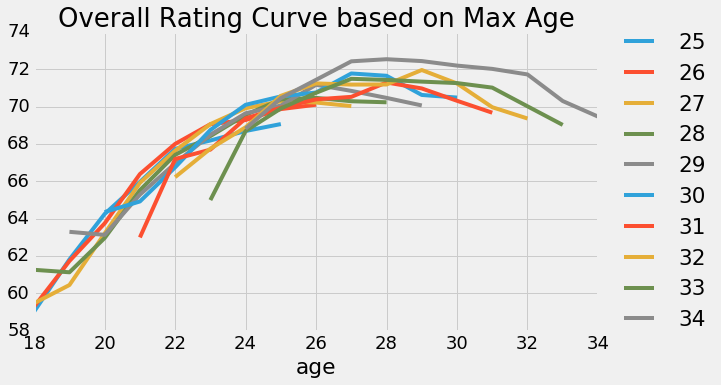

In [13]:
def agecurve(agelist):
    '''Creates a plot of rating by age for soccer players'''
    
    for age in agelist:
        # groupby data by unique id for max age; restrain df to a specific age
        max_age_df = df.groupby('player_api_id').age.max().reset_index()
        max_age_df = max_age_df[max_age_df.age == age]
        
        # subset df for players in max age df; groupby age to get average rating
        age_df = df[df.player_api_id.isin(max_age_df.player_api_id)]
        age_df = age_df.groupby('age').overall_rating.mean().reset_index()
        
        # remove data below age 18; rename columns for graph
        age_df = age_df[age_df.age >= 18]
        age_df.columns = ['age',age]
        
        # create plot with multiple lines
        if age == agelist[0]:
            ax = age_df.plot(kind='line', x='age', y=age, figsize=(9,5))
        else:
            age_df.plot(kind='line', x='age', y=age, ax=ax)

    # add title and adjust legend
    plt.title('Overall Rating Curve based on Max Age')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        
    return

agelist = [i for i in range(25,35)]
agecurve(agelist)